In [1]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

/root/bgem3-finetune/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MultilingualDataset(Dataset):
    def __init__(self, data_list, tokenizer, max_length=128):
        self.data = data_list
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Tokenize all versions of the sentence
        english = self.tokenizer(item["English"], padding="max_length", 
                                truncation=True, max_length=self.max_length, 
                                return_tensors="pt")
        
        etok = self.tokenizer(item["EtoK"], padding="max_length", 
                             truncation=True, max_length=self.max_length, 
                             return_tensors="pt")
        
        ktoe = self.tokenizer(item["KtoE"], padding="max_length", 
                             truncation=True, max_length=self.max_length, 
                             return_tensors="pt")
        
        korean = self.tokenizer(item["Korean"], padding="max_length", 
                               truncation=True, max_length=self.max_length, 
                               return_tensors="pt")
        
        # Return a flat dictionary with prefixed keys
        return {
            "english_input_ids": english["input_ids"].squeeze(0),
            "english_attention_mask": english["attention_mask"].squeeze(0),
            "etok_input_ids": etok["input_ids"].squeeze(0),
            "etok_attention_mask": etok["attention_mask"].squeeze(0),
            "ktoe_input_ids": ktoe["input_ids"].squeeze(0),
            "ktoe_attention_mask": ktoe["attention_mask"].squeeze(0),
            "korean_input_ids": korean["input_ids"].squeeze(0),
            "korean_attention_mask": korean["attention_mask"].squeeze(0)
        }


# --- Helper Function to Calculate Pairwise Loss ---
def calculate_pairwise_loss(
    emb_k: torch.Tensor,
    emb_e: torch.Tensor,
    emb_ktoe: torch.Tensor,
    emb_etok: torch.Tensor,
    loss_type: str = 'cosine' # 'cosine' or 'mse'
) -> torch.Tensor:
    """
    Calculates the sum of pairwise losses (1-cosine_sim or mse)
    between all unique pairs in the quadruplet.

    Args:
        emb_k, emb_e, emb_ktoe, emb_etok: Tensors of shape (batch_size, embedding_dim)
        loss_type: 'cosine' for 1 - cosine_similarity, 'mse' for squared L2 distance.

    Returns:
        Tensor of shape (batch_size,) containing the sum of pairwise losses for each item.
    """
    embeddings = [emb_k, emb_e, emb_ktoe, emb_etok]
    batch_size = emb_k.shape[0]
    total_pairwise_loss = torch.zeros(batch_size, device=emb_k.device)
    num_pairs = 0

    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            emb_i = embeddings[i]
            emb_j = embeddings[j]

            if loss_type == 'cosine':
                # 1 - cosine similarity
                sim = F.cosine_similarity(emb_i, emb_j, dim=1)
                loss = 1.0 - sim
            elif loss_type == 'mse':
                # Squared L2 distance
                loss = torch.sum((emb_i - emb_j) ** 2, dim=1)
            else:
                raise ValueError("loss_type must be 'cosine' or 'mse'")

            total_pairwise_loss += loss
            num_pairs += 1

    # Optional: Average over the number of pairs if desired,
    # but summing works fine as it's consistent.
    # return total_pairwise_loss / num_pairs
    return total_pairwise_loss

# --- Helper Function for Scale Regularization ---
def calculate_scale_regularization(
    emb_k: torch.Tensor,
    emb_e: torch.Tensor,
    emb_ktoe: torch.Tensor,
    emb_etok: torch.Tensor,
    target_norm: float
) -> torch.Tensor:
    """
    Calculates the scale regularization loss.

    Args:
        emb_k, emb_e, emb_ktoe, emb_etok: Tensors of shape (batch_size, embedding_dim)
        target_norm: The target L2 norm scalar value.

    Returns:
        Tensor of shape (batch_size,) containing the scale regularization loss for each item.
    """
    embeddings = [emb_k, emb_e, emb_ktoe, emb_etok]
    total_scale_loss = torch.zeros(emb_k.shape[0], device=emb_k.device)

    for emb in embeddings:
        norm = torch.norm(emb, p=2, dim=1)
        scale_loss = (norm - target_norm) ** 2
        total_scale_loss += scale_loss

    # Average over the 4 embedding types
    return total_scale_loss / len(embeddings)


# --- Loss Function Implementations ---

def compute_cosine_loss_with_scale_reg(
    emb_k: torch.Tensor,
    emb_e: torch.Tensor,
    emb_ktoe: torch.Tensor,
    emb_etok: torch.Tensor,
    target_norm: float,
    lambda_scale: float = 0.01 # Hyperparameter to balance terms
) -> torch.Tensor:
    """
    Computes Loss = (Pairwise 1-CosineSim) + lambda * (Scale Regularization)

    Args:
        emb_k, emb_e, emb_ktoe, emb_etok: Tensors of shape (batch_size, embedding_dim)
        target_norm: The target L2 norm.
        lambda_scale: Weight for the scale regularization term.

    Returns:
        Scalar loss tensor averaged over the batch.
    """
    # Pairwise Cosine Similarity Loss (mean over batch)
    pairwise_loss = calculate_pairwise_loss(emb_k, emb_e, emb_ktoe, emb_etok, loss_type='cosine')
    loss_sim = torch.mean(pairwise_loss)

    # Scale Regularization Loss (mean over batch)
    scale_loss = calculate_scale_regularization(emb_k, emb_e, emb_ktoe, emb_etok, target_norm)
    loss_scale = torch.mean(scale_loss)

    # Total Loss
    total_loss = loss_sim + lambda_scale * loss_scale
    return total_loss

def compute_mse_loss_with_scale_reg(
    emb_k: torch.Tensor,
    emb_e: torch.Tensor,
    emb_ktoe: torch.Tensor,
    emb_etok: torch.Tensor,
    target_norm: float,
    lambda_scale: float = 0.01 # Hyperparameter to balance terms
) -> torch.Tensor:
    """
    Computes Loss = (Pairwise MSE) + lambda * (Scale Regularization)

    Args:
        emb_k, emb_e, emb_ktoe, emb_etok: Tensors of shape (batch_size, embedding_dim)
        target_norm: The target L2 norm.
        lambda_scale: Weight for the scale regularization term.

    Returns:
        Scalar loss tensor averaged over the batch.
    """
    # Pairwise MSE Loss (mean over batch)
    pairwise_loss = calculate_pairwise_loss(emb_k, emb_e, emb_ktoe, emb_etok, loss_type='mse')
    loss_dist = torch.mean(pairwise_loss)

    # Scale Regularization Loss (mean over batch)
    scale_loss = calculate_scale_regularization(emb_k, emb_e, emb_ktoe, emb_etok, target_norm)
    loss_scale = torch.mean(scale_loss)

    # Total Loss
    total_loss = loss_dist + lambda_scale * loss_scale
    return total_loss

# --- Placeholder for Scale-Regularized Contrastive Loss (InfoNCE style) ---
# This requires a more complex setup with negative sampling, often done via in-batch negatives.

def compute_infonce_loss_with_scale_reg(
    emb_k: torch.Tensor,
    emb_e: torch.Tensor,
    emb_ktoe: torch.Tensor,
    emb_etok: torch.Tensor,
    target_norm: float,
    lambda_scale: float = 0.01,
    temperature: float = 0.07
) -> torch.Tensor:
    """
    Computes InfoNCE-style Contrastive Loss + Scale Regularization.
    Assumes in-batch negative sampling.

    Args:
        emb_k, emb_e, emb_ktoe, emb_etok: Tensors of shape (batch_size, embedding_dim)
        target_norm: The target L2 norm.
        lambda_scale: Weight for the scale regularization term.
        temperature: Temperature scaling factor for InfoNCE.

    Returns:
        Scalar loss tensor averaged over the batch.
    """
    device = emb_k.device
    batch_size = emb_k.shape[0]
    embedding_dim = emb_k.shape[1]

    # Concatenate all embeddings for easier similarity matrix calculation
    # Shape: (batch_size * 4, embedding_dim)
    all_embeddings = torch.cat([emb_k, emb_e, emb_ktoe, emb_etok], dim=0)

    # Calculate pairwise cosine similarities (logits)
    # Shape: (batch_size * 4, batch_size * 4)
    logits = F.cosine_similarity(all_embeddings.unsqueeze(1), all_embeddings.unsqueeze(0), dim=2)
    logits /= temperature # Apply temperature scaling

    # Create labels and masks for InfoNCE
    # Labels indicate the index of the positive counterpart within the large batch.
    # For InfoNCE, typically anchor vs one positive, others negative.
    # Here, we have multiple positives per anchor within the quadruplet.

    # Simplified approach: Treat each K as anchor, E/KtoE/EtoK as positives. Repeat for other anchors.
    total_contrastive_loss = torch.tensor(0.0, device=device)
    anchors = [emb_k, emb_e, emb_ktoe, emb_etok]
    anchor_indices = [torch.arange(batch_size) + i * batch_size for i in range(4)] # Indices for K, E, KtoE, EtoK in all_embeddings

    for i in range(4): # Iterate through K, E, KtoE, EtoK as anchors
        current_anchor_indices = anchor_indices[i]
        # Logits for the current anchors vs all embeddings
        anchor_logits = logits[current_anchor_indices] # Shape: (batch_size, batch_size * 4)

        # Create target labels: indicate positive pairs
        # Positive keys are the other embeddings from the *same* original item.
        labels = torch.zeros_like(anchor_logits, dtype=torch.bool)
        for j in range(4):
            if i == j: continue # Don't mark anchor as its own positive
            positive_indices = anchor_indices[j]
            # Mark True where the column index corresponds to a positive pair for the row anchor
            # Need element-wise check. A bit tricky with broadcasted indices.
            # Let's usearange for batch items:
            batch_indices = torch.arange(batch_size, device=device)
            labels[batch_indices, positive_indices] = True

        # InfoNCE Loss calculation: log_softmax over all pairs, gather positives.
        log_prob = F.log_softmax(anchor_logits, dim=1)

        # Sum log probabilities of *all* positive pairs for the anchor
        # Avoid division by zero if no positives (shouldn't happen here)
        mean_log_prob_pos = (log_prob * labels).sum(1) / labels.sum(1).clamp(min=1)

        # Contrastive loss is the negative of the mean log probability of positives
        contrastive_loss = -mean_log_prob_pos
        total_contrastive_loss += contrastive_loss.mean() # Average over batch

    # Average contrastive loss over the 4 anchor types
    loss_contrastive = total_contrastive_loss / 4.0

    # Scale Regularization Loss (mean over batch)
    scale_loss = calculate_scale_regularization(emb_k, emb_e, emb_ktoe, emb_etok, target_norm)
    loss_scale = torch.mean(scale_loss)

    # Total Loss
    total_loss = loss_contrastive + lambda_scale * loss_scale
    return loss_contrastive, loss_scale, total_loss

In [3]:
# --- 기존 Helper Functions (calculate_scale_regularization)은 그대로 사용 ---
# (위에 제공된 코드에 이미 포함되어 있다고 가정)

def calculate_scale_regularization(
    emb_k: torch.Tensor,
    emb_e: torch.Tensor,
    emb_ktoe: torch.Tensor,
    emb_etok: torch.Tensor,
    target_norm: float
) -> torch.Tensor:
    """
    Calculates the scale regularization loss. (Identical to previous version)

    Args:
        emb_k, emb_e, emb_ktoe, emb_etok: Tensors of shape (batch_size, embedding_dim)
        target_norm: The target L2 norm scalar value.

    Returns:
        Tensor of shape (batch_size,) containing the scale regularization loss for each item.
    """
    embeddings = [emb_k, emb_e, emb_ktoe, emb_etok]
    total_scale_loss = torch.zeros(emb_k.shape[0], device=emb_k.device)

    for emb in embeddings:
        norm = torch.norm(emb, p=2, dim=1)
        scale_loss = (norm - target_norm) ** 2
        total_scale_loss += scale_loss

    # Average over the 4 embedding types
    return total_scale_loss / len(embeddings)

# --- New Loss Function with English Anchor ---

def compute_cosine_loss_anchor_e_with_scale_reg(
    emb_k: torch.Tensor,
    emb_e: torch.Tensor,
    emb_ktoe: torch.Tensor,
    emb_etok: torch.Tensor,
    target_norm: float,
    lambda_scale: float = 0.01 # Hyperparameter to balance terms
) -> torch.Tensor:
    """
    Computes Loss where K, KtoE, EtoK embeddings are pulled towards a
    fixed English anchor (E), plus scale regularization on all embeddings.

    Loss = (1-cos(K, E_detach)) + (1-cos(KtoE, E_detach)) + (1-cos(EtoK, E_detach))
           + lambda * ScaleReg(K, E, KtoE, EtoK)

    Args:
        emb_k, emb_e, emb_ktoe, emb_etok: Tensors of shape (batch_size, embedding_dim)
        target_norm: The target L2 norm for scale regularization.
        lambda_scale: Weight for the scale regularization term.

    Returns:
        Scalar loss tensor averaged over the batch.
    """
    # --- Anchored Cosine Similarity Loss ---
    # Detach emb_e so gradients don't flow back to it from the similarity loss
    emb_e_detached = emb_e.detach()

    # Calculate similarity only between non-English embeddings and the English anchor
    sim_ke = F.cosine_similarity(emb_k, emb_e_detached, dim=1)
    sim_ktoee = F.cosine_similarity(emb_ktoe, emb_e_detached, dim=1)
    sim_etoke = F.cosine_similarity(emb_etok, emb_e_detached, dim=1)

    # Calculate the loss (1 - similarity) for each pair w.r.t the anchor
    loss_k_anchor = 1.0 - sim_ke
    loss_ktoe_anchor = 1.0 - sim_ktoee
    loss_etok_anchor = 1.0 - sim_etoke

    # Sum the anchored similarity losses for each item in the batch
    # Shape: (batch_size,)
    total_anchor_sim_loss = loss_k_anchor + loss_ktoe_anchor + loss_etok_anchor

    # Average the similarity loss over the batch
    loss_sim_anchor_mean = torch.mean(total_anchor_sim_loss)

    # --- Scale Regularization Loss (applied to ALL embeddings) ---
    # Use the original emb_e (with gradients enabled) for scale regularization
    scale_loss = calculate_scale_regularization(emb_k, emb_e, emb_ktoe, emb_etok, target_norm)
    loss_scale_mean = torch.mean(scale_loss)

    # --- Total Loss ---
    total_loss = loss_sim_anchor_mean + lambda_scale * loss_scale_mean
    return total_loss

In [14]:
class EmbeddingFinetuner:
    def __init__(self, model_name="BAAI/bge-m3", device="cuda" if torch.cuda.is_available() else "cpu"):
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        
        # Save the original model for comparison
        self.original_model = AutoModel.from_pretrained(model_name).to(device)
        self.original_model.eval()  # Set to evaluation mode
    
    def save_model(self, path="finetuned_model"):
        """
        모델을 저장합니다.
        
        Args:
            path (str): 모델을 저장할 경로/파일명 (확장자 없이)
        """
        # 모델 상태 저장
        torch.save(self.model.state_dict(), f"{path}.pt")
        
        # 설정 정보 저장 (선택사항)
        import json
        config = {
            "model_name": self.model.config._name_or_path,
            "saved_date": str(datetime.datetime.now())
        }
        
        with open(f"{path}_config.json", "w") as f:
            json.dump(config, f)
        
        print(f"모델이 '{path}.pt'에 저장되었습니다.")

    def load_model(self, path="finetuned_model"):
        """
        저장된 모델을 불러옵니다.
        
        Args:
            path (str): 불러올 모델 파일 경로 (확장자 없이)
        """
        # 모델 상태 불러오기
        self.model.load_state_dict(torch.load(f"{path}.pt"))
        self.model.eval()  # 평가 모드로 설정
        print(f"모델이 '{path}.pt'에서 불러와졌습니다.")

    def get_embedding(self, model, input_ids, attention_mask):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.pooler_output
    
    def finetune(self, train_dataloader, num_epochs=5, lr=1e-5):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        
        self.model.train()
        
        for epoch in range(num_epochs):
            total_loss = 0
            
            for batch in train_dataloader:
                optimizer.zero_grad()
                
                # Move all inputs to device
                batch = {k: v.to(self.device) for k, v in batch.items()}
                
                # Get embeddings for all text versions
                english_embedding = self.get_embedding(
                    self.model, 
                    batch["english_input_ids"], 
                    batch["english_attention_mask"]
                )
                
                etok_embedding = self.get_embedding(
                    self.model, 
                    batch["etok_input_ids"], 
                    batch["etok_attention_mask"]
                )
                
                ktoe_embedding = self.get_embedding(
                    self.model, 
                    batch["ktoe_input_ids"], 
                    batch["ktoe_attention_mask"]
                )
                
                korean_embedding = self.get_embedding(
                    self.model, 
                    batch["korean_input_ids"], 
                    batch["korean_attention_mask"]
                )
                
                embeddings = [english_embedding, etok_embedding, ktoe_embedding, korean_embedding]

                batch_size = english_embedding.size(0)
                num_embeddings = len(embeddings)
                num_pairs = num_embeddings * (num_embeddings - 1) // 2
                # loss = 0
                
                # for i in range(num_embeddings):
                #     for j in range(i + 1, num_embeddings):
                #         # Colculate contrastive loss
                #         cos_sim = F.cosine_similarity(embeddings[i], embeddings[j], dim=-1)
                #         loss += (1 - cos_sim).mean()
                #         # loss += torch.sum(torch.norm(embeddings[i] - embeddings[j], dim=1))
                        
                #         # Calculate regularization loss
                #         total_scale_loss = torch.zeros(english_embedding.shape[0], device=english_embedding.device)

                #         for emb in embeddings:
                #             norm = torch.norm(emb, p=2, dim=1)
                #             scale_loss = (norm - target_norm) ** 2
                #             total_scale_loss += scale_loss
                
                # loss = loss / (num_pairs * batch_size)
                
                contrastive_loss, scale_loss, total_loss = compute_infonce_loss_with_scale_reg(
                    english_embedding, etok_embedding, ktoe_embedding, korean_embedding,
                    target_norm=8.0,  # Example target norm
                    lambda_scale=0.2  # Example scale regularization weight
                )
                loss = total_loss / (num_pairs * batch_size)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss/len(train_dataloader):.4f}, Contrastive Loss: {contrastive_loss/len(train_dataloader):.4f}, Scale Loss: {scale_loss/len(train_dataloader):.4f}")
    
    def compute_embeddings(self, data_loader, model):
        # Set model to evaluation mode
        model.eval()
        
        embeddings = {
            "english": [],
            "etok": [],
            "ktoe": [],
            "korean": []
        }
        
        with torch.no_grad():
            for batch in data_loader:
                # Move all inputs to device
                batch = {k: v.to(self.device) for k, v in batch.items()}
                
                # Compute embeddings for each type
                english_emb = self.get_embedding(
                    model, 
                    batch["english_input_ids"], 
                    batch["english_attention_mask"]
                ).cpu().numpy()
                
                etok_emb = self.get_embedding(
                    model, 
                    batch["etok_input_ids"], 
                    batch["etok_attention_mask"]
                ).cpu().numpy()
                
                ktoe_emb = self.get_embedding(
                    model, 
                    batch["ktoe_input_ids"], 
                    batch["ktoe_attention_mask"]
                ).cpu().numpy()
                
                korean_emb = self.get_embedding(
                    model, 
                    batch["korean_input_ids"], 
                    batch["korean_attention_mask"]
                ).cpu().numpy()
                
                # Store embeddings
                embeddings["english"].append(english_emb)
                embeddings["etok"].append(etok_emb)
                embeddings["ktoe"].append(ktoe_emb)
                embeddings["korean"].append(korean_emb)
        
        # Concatenate all batches
        for key in embeddings:
            if embeddings[key]:  # Check if the list is not empty
                embeddings[key] = np.concatenate(embeddings[key], axis=0)
        
        return embeddings
    
    def evaluate_embeddings(self, data_loader):
        original_embeddings = self.compute_embeddings(data_loader, self.original_model)
        finetuned_embeddings = self.compute_embeddings(data_loader, self.model)
        
        return original_embeddings, finetuned_embeddings
    
    def visualize_with_pca(self, original_embeddings, finetuned_embeddings):
        # Stack all embeddings for fitting PCA
        original_stack = np.vstack([original_embeddings[k] for k in original_embeddings])
        finetuned_stack = np.vstack([finetuned_embeddings[k] for k in finetuned_embeddings])
        
        # Fit PCA on combined data
        pca_original = PCA(n_components=2)
        pca_finetuned = PCA(n_components=2)
        
        # Transform each set of embeddings
        original_pca_result = {}
        finetuned_pca_result = {}
        
        # Fit PCA on all original embeddings
        pca_original.fit(original_stack)
        for key in original_embeddings:
            original_pca_result[key] = pca_original.transform(original_embeddings[key])
        
        # Fit PCA on all finetuned embeddings
        pca_finetuned.fit(finetuned_stack)
        for key in finetuned_embeddings:
            finetuned_pca_result[key] = pca_finetuned.transform(finetuned_embeddings[key])
        
        # Create figure for visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        
        # Define colors and markers for each type
        colors = {
            "english": "blue",
            "etok": "green",
            "ktoe": "red",
            "korean": "purple"
        }
        
        markers = {
            "english": "o",
            "etok": "s",
            "ktoe": "^",
            "korean": "D"
        }
        
        # Plot original embeddings
        for key in original_pca_result:
            ax1.scatter(
                original_pca_result[key][:, 0], 
                original_pca_result[key][:, 1],
                color=colors[key],
                marker=markers[key],
                label=key,
                alpha=0.7
            )
        
        ax1.set_title("Original Model Embeddings (Before Fine-tuning)")
        ax1.legend()
        ax1.grid(True)
        
        # Plot finetuned embeddings
        for key in finetuned_pca_result:
            ax2.scatter(
                finetuned_pca_result[key][:, 0], 
                finetuned_pca_result[key][:, 1],
                color=colors[key],
                marker=markers[key],
                label=key,
                alpha=0.7
            )
        
        ax2.set_title("Fine-tuned Model Embeddings")
        ax2.legend()
        ax2.grid(True)
        
        plt.suptitle("Comparing Embeddings Before and After Fine-tuning")
        plt.tight_layout()
        plt.savefig("embedding_comparison.png")
        plt.show()
        
        # Calculate and report average distances
        print("\nAverage L2 distances from English embeddings:")
        print("Before fine-tuning:")
        for key in ["etok", "ktoe", "korean"]:
            avg_dist = np.mean(np.linalg.norm(
                original_embeddings["english"] - original_embeddings[key], axis=1
            ))
            print(f"  English to {key}: {avg_dist:.4f}")
        
        print("\nAfter fine-tuning:")
        for key in ["etok", "ktoe", "korean"]:
            avg_dist = np.mean(np.linalg.norm(
                finetuned_embeddings["english"] - finetuned_embeddings[key], axis=1
            ))
            print(f"  English to {key}: {avg_dist:.4f}")

In [5]:
import json
import random

file_path = "code-switch.json"
file_path1 = "code-switch1.json"
file_path2 = "code-switch2.json"
file_paths = [file_path, file_path1, file_path2]

# Load the JSON data
data = []
for fp in file_paths:
    with open(fp, "r", encoding="utf-8") as f:
        data += json.load(f)

# with open(file_path, "r", encoding="utf-8") as f:
#     data = json.load(f)
# with open(file_path1, "r", encoding="utf-8") as f:
#     data1 = json.load(f)
# with open(file_path2, "r", encoding="utf-8") as f:
#     data2 = json.load(f)

# # Combine the data
# data = data + data1 + data2

# Shuffle the data for randomness
np.random.seed(42)
np.random.shuffle(data)

# Split the data into 80% training and 20% validation
train_size = int(0.8 * len(data))
train_data = data[:train_size]
val_data = data[train_size:]
print("# Train data:", len(train_data))
print("# Validation data:", len(val_data))

# Train data: 215
# Validation data: 54


In [6]:
# Initialize the finetuner
finetuner = EmbeddingFinetuner()

# Create dataset and dataloader
dataset = MultilingualDataset(data, finetuner.tokenizer)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    # model.to(device) # 모델을 GPU로 이동

    # 현재 활성 텐서들이 사용 중인 GPU 메모리 (Bytes)
    allocated_memory = torch.cuda.memory_allocated(device=device)
    # PyTorch 캐싱 할당자가 예약한 총 GPU 메모리 (Bytes)
    reserved_memory = torch.cuda.memory_reserved(device=device)

    print(f"할당된 GPU 메모리 (Allocated): {allocated_memory / (1024**3):.2f} GB")
    print(f"예약된 GPU 메모리 (Reserved): {reserved_memory / (1024**3):.2f} GB")

    # 더 상세한 메모리 사용 현황 출력
    # print(torch.cuda.memory_summary(device=device, abbreviated=False))
else:
    print("CUDA (GPU)를 사용할 수 없습니다.")
    # CPU 메모리 사용량은 psutil 같은 외부 라이브러리로 확인해야 합니다.
    # import psutil
    # process = psutil.Process(os.getpid())
    # print(f"현재 프로세스 RAM 사용량: {process.memory_info().rss / (1024**2):.2f} MB")

할당된 GPU 메모리 (Allocated): 4.23 GB
예약된 GPU 메모리 (Reserved): 4.25 GB


Epoch 1/5, Total Loss: 0.0318, Contrastive Loss: 0.0304, Scale Loss: 0.0006
Epoch 2/5, Total Loss: 0.0322, Contrastive Loss: 0.0308, Scale Loss: 0.0005
Epoch 3/5, Total Loss: 0.0300, Contrastive Loss: 0.0286, Scale Loss: 0.0011
Epoch 4/5, Total Loss: 0.0296, Contrastive Loss: 0.0283, Scale Loss: 0.0005
Epoch 5/5, Total Loss: 0.0289, Contrastive Loss: 0.0277, Scale Loss: 0.0004
모델이 'multilingual_embedding_model.pt'에 저장되었습니다.


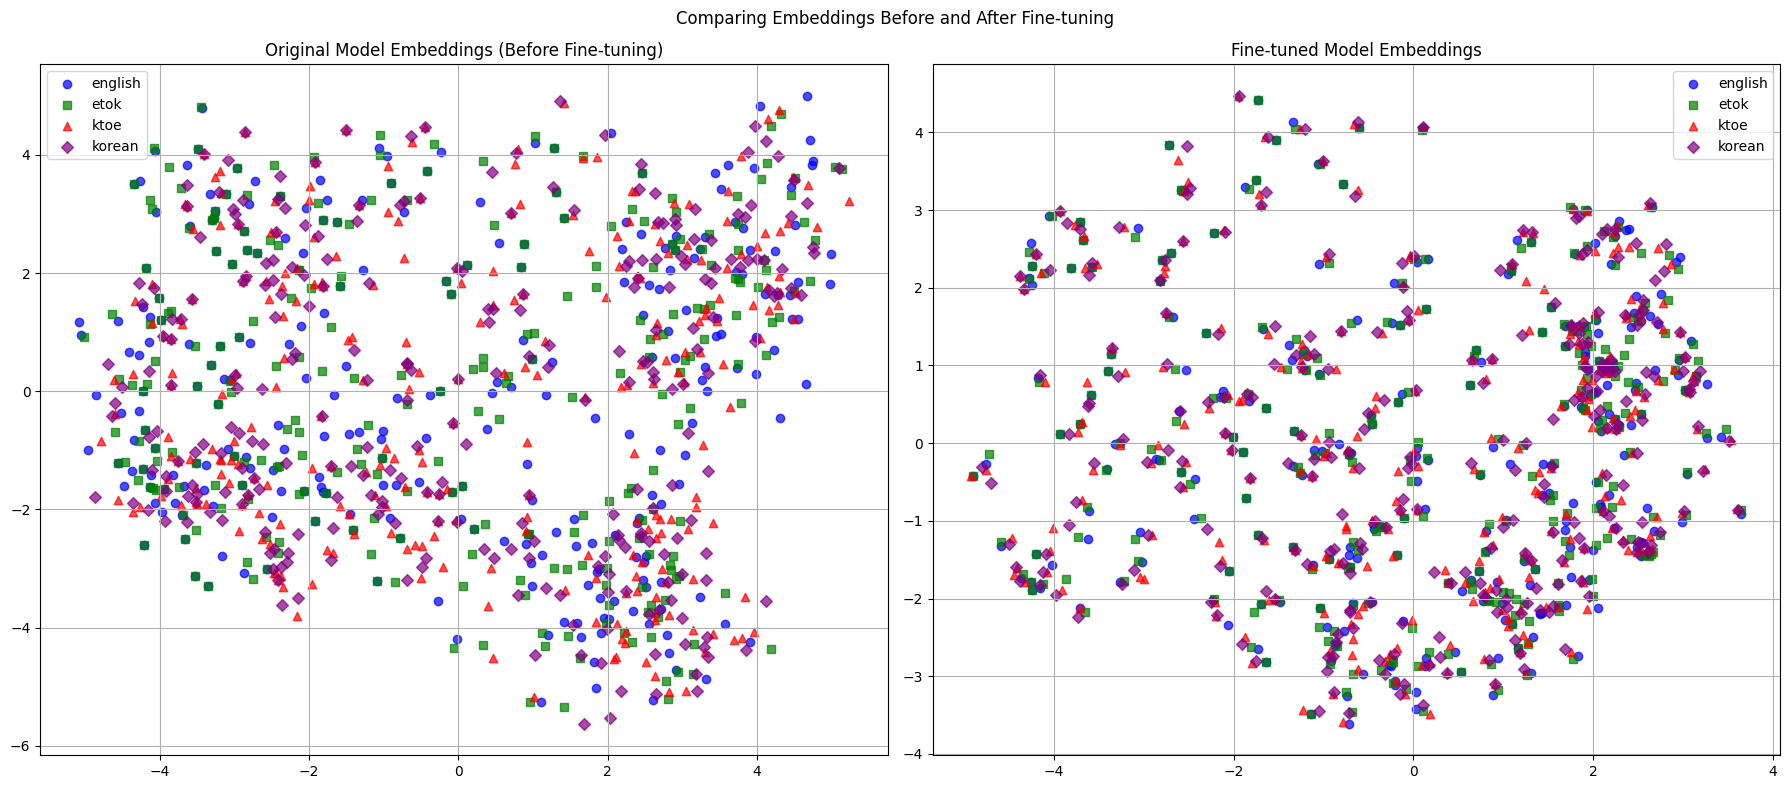


Average L2 distances from English embeddings:
Before fine-tuning:
  English to etok: 4.2387
  English to ktoe: 7.1503
  English to korean: 8.1663

After fine-tuning:
  English to etok: 0.3517
  English to ktoe: 0.6810
  English to korean: 0.7104


In [15]:
# Initialize the finetuner
finetuner = EmbeddingFinetuner()

# Create dataset and dataloader
dataset = MultilingualDataset(data, finetuner.tokenizer)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

# Finetune the model
finetuner.finetune(dataloader, num_epochs=5, lr=2e-5)

finetuner.save_model("multilingual_embedding_model")

# Evaluate embeddings
original_embeddings, finetuned_embeddings = finetuner.evaluate_embeddings(dataloader)

# Visualize results
finetuner.visualize_with_pca(original_embeddings, finetuned_embeddings)

In [21]:
torch.cuda.empty_cache()

In [16]:
from multiprocessing import pool
from sentence_transformers import SentenceTransformer
from sentence_transformers.models import Transformer, Pooling

# 1. 원래 모델과 토크나이저 로드
model = torch.load("multilingual_embedding_model.pt", map_location=torch.device('cpu'))  # 로컬 .pt 파일
# tokenizer = finetuner.tokenizer

# # 2. 모델을 SentenceTransformer로 래핑
# # modules는 Transformer와 Pooling 레이어로 구성
transformer = Transformer(model_name_or_path="BAAI/bge-m3", max_seq_length=128)
transformer.auto_model = finetuner.model  # 로드한 모델로 교체
pooling = Pooling(finetuner.model.config.hidden_size, pooling_mode="mean")  # bge-m3은 mean pooling 사용

st_model = SentenceTransformer(modules=[transformer, pooling])


In [ ]:
# 3. 변환된 모델 저장
st_model.save("bge_m3_finetuned_local")
print("모델이 'bge_m3_finetuned_local'에 저장되었습니다.")

In [23]:
from utils.config import get_secret

In [ ]:
from huggingface_hub import login

login(token=get_secret("HF_TOKEN"))

In [17]:
try:
    repo_id = "hyoseok1989/bge-m3-finetuned"
    commit_msg = "Fine-tuned BGE-M3 for Korean-English code-switching task"

    st_model.save_to_hub(
        repo_id=repo_id,
        commit_message=commit_msg,
        private=False,
        exist_ok=True,  # True if overwrite the existing model
    )
    print(f"모델이 Hugging Face Hub에 성공적으로 업로드되었습니다: {repo_id}")

except Exception as e:
    print(f"모델 업로드 중 오류 발생: {e}")

The `save_to_hub` method is deprecated and will be removed in a future version of SentenceTransformers. Please use `push_to_hub` instead for future model uploads.


모델 업로드 중 오류 발생: 401 Client Error: Unauthorized for url: https://huggingface.co/api/repos/create (Request ID: Root=1-6807bada-29d07d4e182c791f5d48ebc3;3efb25cd-b9b8-4f03-a68a-c688d034b8f2)

Invalid username or password.
